# fbprophet Refresh

Refresher on model based on GAM

In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
#plt.style.use('fivethirtyeight')

# reference
# https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-prophet

In [2]:
data_source_dir = r'/home/jasonchandatascience/competition_prep/data/hourly_energy_consumption'

In [3]:
def GetPath(file, directory=data_source_dir):
    return os.path.join(directory, file)

In [4]:
# had to edit permission using !chmod 644 *.csv for all csv files
pjme = pd.read_csv(GetPath('PJME_hourly.csv'), index_col=[0], parse_dates=[0])

# Data

In [5]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [6]:
pjme.shape

(145366, 1)

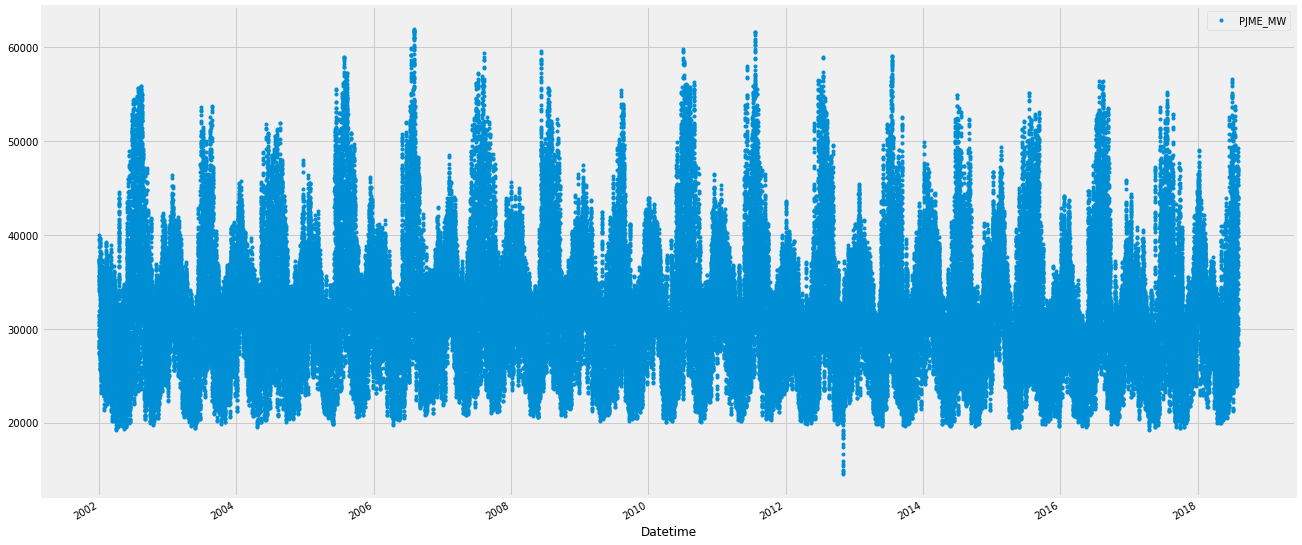

In [7]:
pjme.plot(style='.', figsize=(20, 10))

# Creating Time Features

In [5]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [6]:
X, y = create_features(pjme, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)

In [10]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


In [11]:
features_and_target.isnull().sum(axis=0)

hour          0
dayofweek     0
quarter       0
month         0
year          0
dayofyear     0
dayofmonth    0
weekofyear    0
PJME_MW       0
dtype: int64

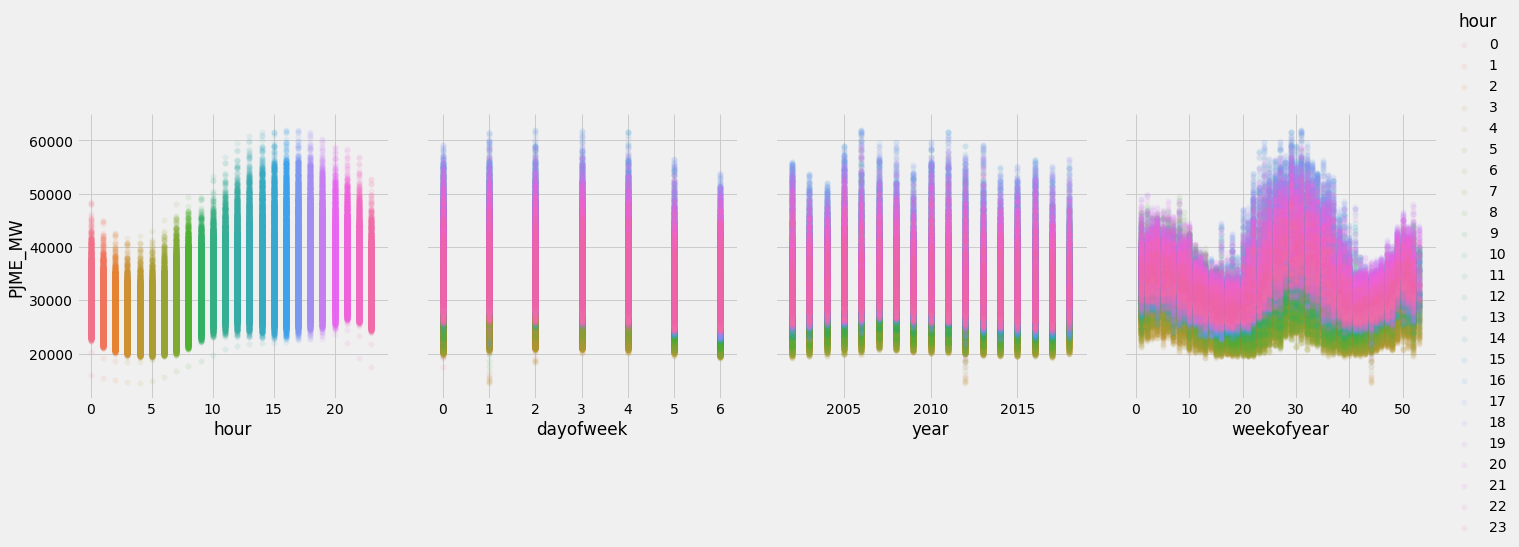

In [43]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek','year','weekofyear'],
             y_vars='PJME_MW',
             height=5,
             plot_kws={'alpha':0.1, 'linewidth':0}
            )

# Train/Test Split

In [7]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

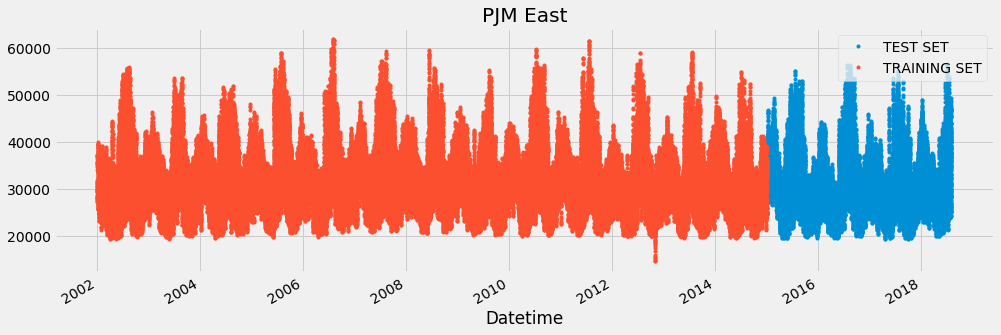

In [45]:
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

# Basic Prophet Model

In [46]:
pjme_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'})

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [47]:
# Setup and train model
model = Prophet()
model.fit(pjme_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'}))

In [51]:
# note that doing it this way will exclude the training set date time
pjme_test_fcst = model.predict(df=pjme_test.reset_index().rename(columns={'Datetime':'ds'}))

# if want to include training set data, use model.make_future_dataframe(periods=pjme_test.shape[0])

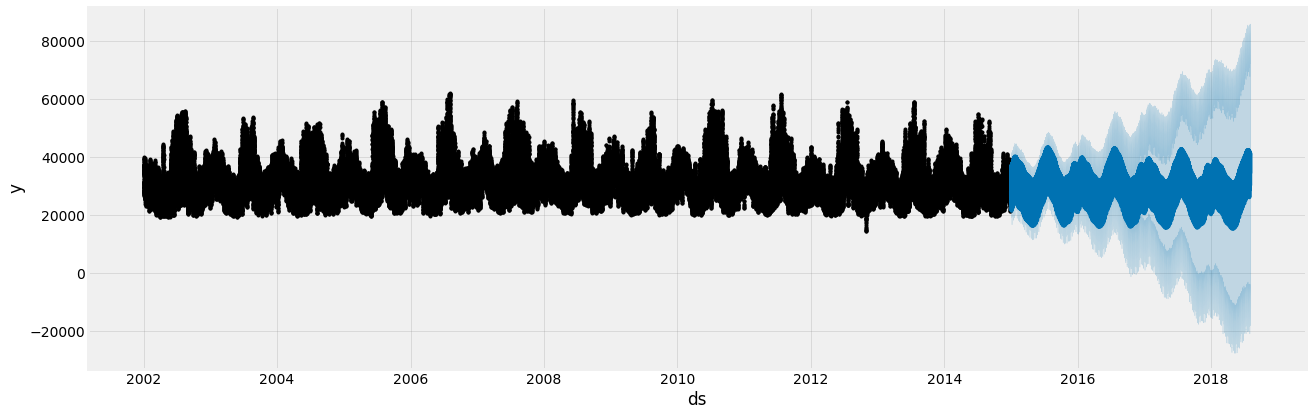

In [53]:
fig1 = model.plot(pjme_test_fcst)
fig1.set_figwidth(20)

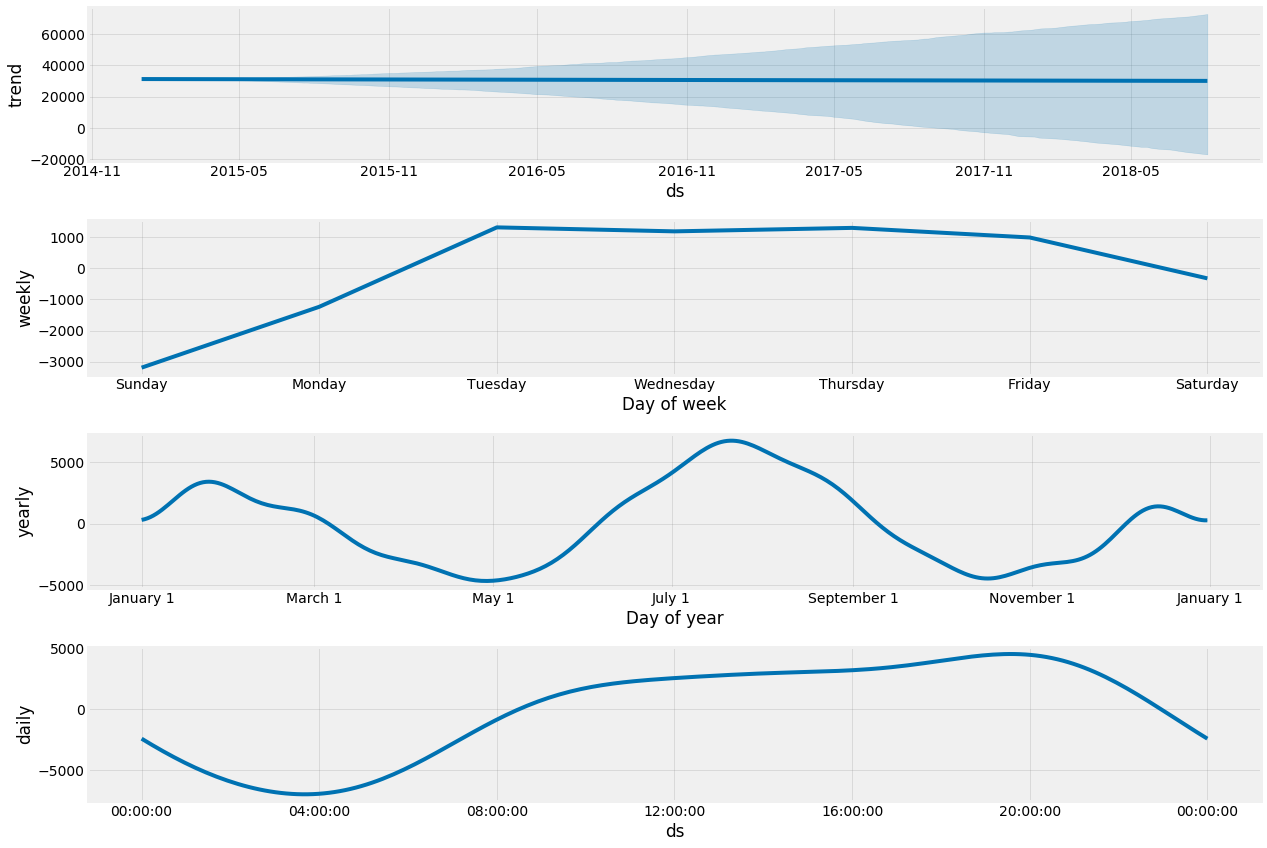

In [56]:
fig = model.plot_components(pjme_test_fcst)
fig.set_figwidth(20)

In [60]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31208.942822,23707.720174,32516.752294,31208.942822,31208.942822,-2860.005912,-2860.005912,-2860.005912,-4430.369014,...,1281.395157,1281.395157,1281.395157,288.967945,288.967945,288.967945,0.0,0.0,0.0,28348.936910
1,2015-01-01 02:00:00,31208.905497,22200.910428,31178.577999,31208.905497,31208.905497,-4364.449078,-4364.449078,-4364.449078,-5927.335044,...,1272.633644,1272.633644,1272.633644,290.252322,290.252322,290.252322,0.0,0.0,0.0,26844.456420
2,2015-01-01 03:00:00,31208.868173,21686.166163,30453.239461,31208.868173,31208.868173,-5236.161650,-5236.161650,-5236.161650,-6790.406226,...,1262.666352,1262.666352,1262.666352,291.578223,291.578223,291.578223,0.0,0.0,0.0,25972.706523
3,2015-01-01 04:00:00,31208.830848,21234.241830,30758.122246,31208.830848,31208.830848,-5377.671178,-5377.671178,-5377.671178,-6922.233777,...,1251.616925,1251.616925,1251.616925,292.945674,292.945674,292.945674,0.0,0.0,0.0,25831.159671
4,2015-01-01 05:00:00,31208.793524,21651.057104,31043.993807,31208.793524,31208.793524,-4703.276175,-4703.276175,-4703.276175,-6237.252092,...,1239.621217,1239.621217,1239.621217,294.354700,294.354700,294.354700,0.0,0.0,0.0,26505.517349


# Evaluation

In [15]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



In [ ]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

# Adding Holidays

In [13]:
model_h = Prophet()

In [14]:
model_h.add_country_holidays(country_name='US')

In [15]:
model_h.fit(pjme_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'}))

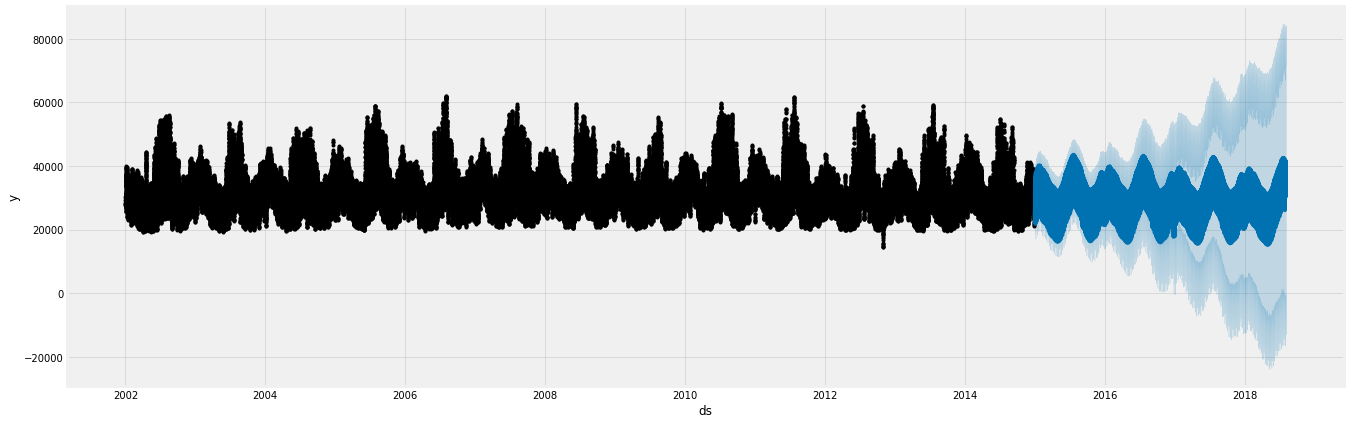

In [18]:
pjme_test_fcst_h = model_h.predict(df=pjme_test.reset_index().rename(columns={'Datetime':'ds'}))
fig2 = model_h.plot(pjme_test_fcst_h)
fig2.set_figwidth(20)

In [19]:
model_h.train_holiday_names

0                  New Year's Day
1     Martin Luther King, Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10      New Year's Day (Observed)
11    Independence Day (Observed)
12       Christmas Day (Observed)
13        Veterans Day (Observed)
dtype: object

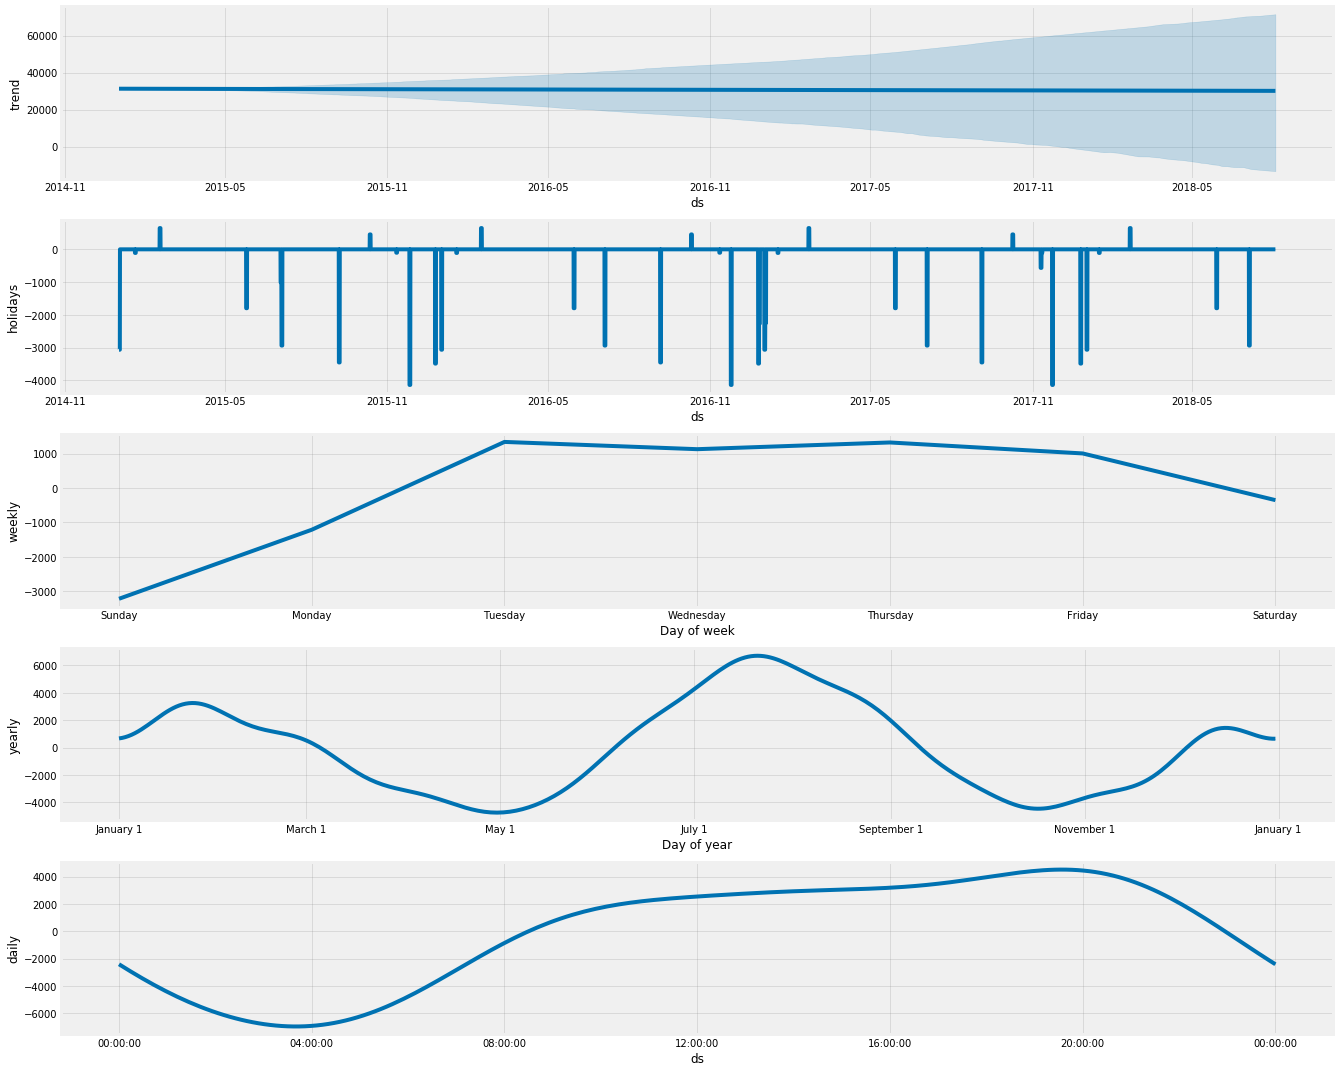

In [21]:
fig_2_comp = model_h.plot_components(pjme_test_fcst_h)
fig_2_comp.set_figwidth(20)

In [23]:
pjme_test_fcst_h.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Christmas Day (Observed)', 'Christmas Day (Observed)_lower',
       'Christmas Day (Observed)_upper', 'Columbus Day', 'Columbus Day_lower',
       'Columbus Day_upper', 'Independence Day', 'Independence Day_lower',
       'Independence Day_upper', 'Independence Day (Observed)',
       'Independence Day (Observed)_lower',
       'Independence Day (Observed)_upper', 'Labor Day', 'Labor Day_lower',
       'Labor Day_upper', 'Martin Luther King, Jr. Day',
       'Martin Luther King, Jr. Day_lower',
       'Martin Luther King, Jr. Day_upper', 'Memorial Day',
       'Memorial Day_lower', 'Memorial Day_upper', 'New Year's Day',
       'New Year's Day_lower', 'New Year's Day_upper',
       'New Year's Day (Observed)', 'New Year's Day (Observed)_lower',
       'New Year's Day (Observed)_upper', 'Thanksgiving', 'Thanksgiving_lower',
       

In [27]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_h['yhat'])

16.56249460599049

In [8]:
?Prophet

Init signature: Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000)
Docstring:     
Prophet forecaster.

Parameters
----------
growth: String 'linear' or 'logistic' to specify a linear or logistic
    trend.
changepoints: List of dates at which to include potential changepoints. If
    not specified, potential changepoints are selected automatically.
n_changepoints: Number of potential changepoints to include. Not used
    if input `changepoints` is supplied. If `changepoints` is not supplied,
    then n_changepoints potential changepoints are selected uniformly from
    the first `changepoint_range` proportion of the history.
changepoint_range: Proportion of history in which trend ch

# Parameter Tuning

Can add the following attributes:
* increase seasonality prior scale
* increase changepoint prior scale
* manually add seasonality and incrase fourier order - Increasing it allows the model for fitting the seasonal patterns that change more quickly.

In [70]:
model_t = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False, seasonality_prior_scale=35, changepoint_prior_scale=30, seasonality_mode='multiplicative')

In [71]:
model_t.add_seasonality(
    
    name='monthly',
    period=30.5,
    fourier_order = 55

)

model_t.add_seasonality(
    
    name='daily',
    period=1,
    fourier_order = 15

)

model_t.add_seasonality(
    
    name='yearly',
    period=365.25,
    fourier_order = 20

)

model_t.add_seasonality(
    
    name='weekly',
    period=7,
    fourier_order = 20

)

model_t.add_seasonality(
    
    name='quarterly',
    period=365.25/4,
    fourier_order = 5,
    prior_sc

)

In [72]:
model_t.fit(pjme_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'}))

In [73]:
pjme_test_fcst_t = model_t.predict(df=pjme_test.reset_index().rename(columns={'Datetime':'ds'}))

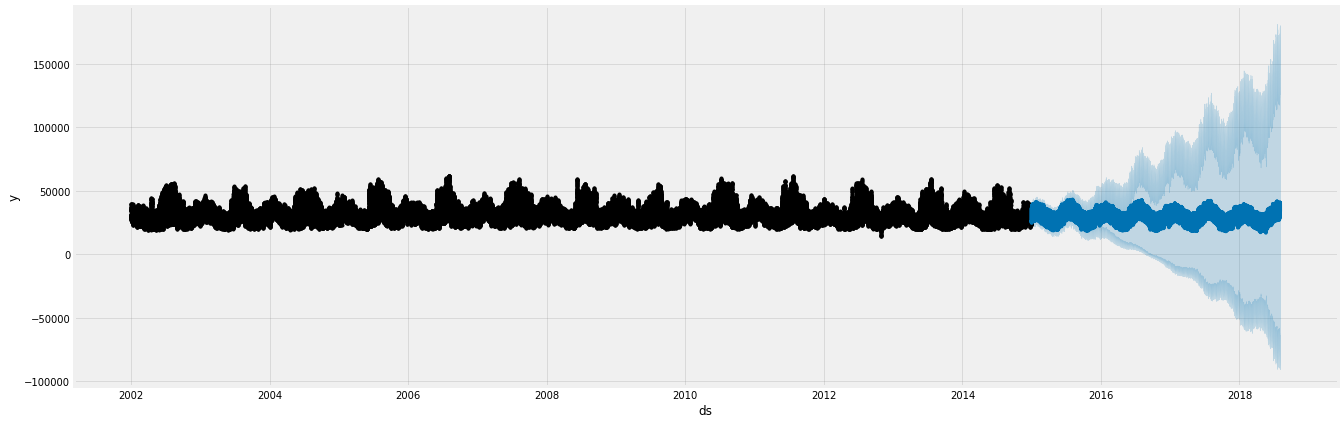

In [74]:
fig3 = model_t.plot(pjme_test_fcst_t)
fig3.set_figwidth(20)

In [75]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_t['yhat'])

16.34325327642453

# Check China Holidays

outside of prophet build in, can also make own df. Also useful for generating features to feed into other models

## fbprophet built-in

In [80]:
m = Prophet()
m.add_country_holidays(country_name='CN')

In [83]:
m.fit(pjme_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'}))

In [85]:
m.train_holiday_names

0          New Year's Day
1        Chinese New Year
2       Tomb-Sweeping Day
3               Labor Day
4    Dragon Boat Festival
5     Mid-Autumn Festival
6            National Day
dtype: object

## workalendar

only supports 2018, 2019

In [89]:
from datetime import date
from workalendar.asia import China

In [90]:
cal = China()

In [95]:
cal_cn = pd.DataFrame(cal.holidays(), columns=['ds', 'holiday'])

In [97]:
cal_cn['lower_window'] = -1
cal_cn['upper_window'] = 1

In [98]:
cal_cn

,ds,holiday,lower_window,upper_window
0,2019-01-01,New year,-1,1
1,2019-02-04,Chinese New Year's eve,-1,1
2,2019-02-05,Chinese New Year,-1,1
3,2019-02-06,Spring Festival,-1,1
4,2019-02-07,Spring Festival,-1,1
5,2019-02-08,Spring Festival,-1,1
6,2019-02-09,Spring Festival,-1,1
7,2019-02-10,Spring Festival,-1,1
8,2019-04-05,Ching Ming Festival,-1,1
9,2019-05-01,Labour Day Holiday,-1,1


## Chinese Calendar

In [8]:
import datetime

# 判断 2018年4月30号 是不是节假日
from chinese_calendar import is_workday, is_holiday
april_last = datetime.date(2018, 4, 30)

In [9]:
is_holiday(april_last)


True

In [10]:
is_workday(april_last)


False

In [11]:
import chinese_calendar as calendar

In [12]:
cal_cn = pd.DataFrame(list(calendar.holidays.items()), columns=['ds', 'holiday'])

In [13]:
cal_cn['lower_window'] = -1
cal_cn['upper_window'] = 1 

In [14]:
cal_cn.head()

,ds,holiday,lower_window,upper_window
0,2004-01-01,New Year's Day,-1,1
1,2004-01-22,Spring Festival,-1,1
2,2004-01-23,Spring Festival,-1,1
3,2004-01-24,Spring Festival,-1,1
4,2004-01-25,Spring Festival,-1,1


In [15]:
pjme_train_cn = pjme_train.loc['2004-01-01':]
pjme_train_cn = pjme_train_cn.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'})

In [16]:
model_cn = Prophet(holidays=cal_cn)


In [17]:
model_cn.fit(pjme_train_cn)

In [18]:
forecast_cn = model_cn.predict(df=pjme_test.reset_index().rename(columns={'Datetime':'ds'}))

In [19]:
forecast_cn.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Anti-Fascist 70th Day,Anti-Fascist 70th Day_lower,Anti-Fascist 70th Day_upper,Dragon Boat Festival,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31091.144089,21601.705453,30373.430863,31091.144089,31091.144089,0.0,0.0,0.0,0.0,...,1262.354990,1262.354990,1262.354990,205.618533,205.618533,205.618533,0.0,0.0,0.0,26270.847651
1,2015-01-01 02:00:00,31091.091064,20187.554328,29465.881734,31091.091064,31091.091064,0.0,0.0,0.0,0.0,...,1254.542566,1254.542566,1254.542566,206.035120,206.035120,206.035120,0.0,0.0,0.0,24768.583399
2,2015-01-01 03:00:00,31091.038038,19255.124570,27892.154628,31091.038038,31091.038038,0.0,0.0,0.0,0.0,...,1245.579334,1245.579334,1245.579334,206.495751,206.495751,206.495751,0.0,0.0,0.0,23900.130231
3,2015-01-01 04:00:00,31090.985013,19350.016928,28491.314606,31090.985013,31090.985013,0.0,0.0,0.0,0.0,...,1235.587474,1235.587474,1235.587474,207.000496,207.000496,207.000496,0.0,0.0,0.0,23764.069921
4,2015-01-01 05:00:00,31090.931987,20117.943498,28594.197395,31090.931987,31090.931987,0.0,0.0,0.0,0.0,...,1224.700482,1224.700482,1224.700482,207.549420,207.549420,207.549420,0.0,0.0,0.0,24445.276034


In [20]:
forecast_cn.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Anti-Fascist 70th Day', 'Anti-Fascist 70th Day_lower',
       'Anti-Fascist 70th Day_upper', 'Dragon Boat Festival',
       'Dragon Boat Festival_lower', 'Dragon Boat Festival_upper',
       'Labour Day', 'Labour Day_lower', 'Labour Day_upper',
       'Mid-autumn Festival', 'Mid-autumn Festival_lower',
       'Mid-autumn Festival_upper', 'National Day', 'National Day_lower',
       'National Day_upper', 'New Year's Day', 'New Year's Day_lower',
       'New Year's Day_upper', 'Spring Festival', 'Spring Festival_lower',
       'Spring Festival_upper', 'Tomb-sweeping Day', 'Tomb-sweeping Day_lower',
       'Tomb-sweeping Day_upper', 'additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'daily', 'daily_lower', 'daily_upper',
       'holidays', 'holidays_lower', 'holidays_upper', 'weekly',
       'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multipli

In [26]:
model_cn.construct_holiday_dataframe(cal_cn['ds'])

,ds,holiday,lower_window,upper_window
0,2004-01-01,New Year's Day,-1.0,1.0
1,2004-01-22,Spring Festival,-1.0,1.0
2,2004-01-23,Spring Festival,-1.0,1.0
3,2004-01-24,Spring Festival,-1.0,1.0
4,2004-01-25,Spring Festival,-1.0,1.0
5,2004-01-26,Spring Festival,-1.0,1.0
6,2004-01-27,Spring Festival,-1.0,1.0
7,2004-01-28,Spring Festival,-1.0,1.0
8,2004-05-01,Labour Day,-1.0,1.0
9,2004-05-02,Labour Day,-1.0,1.0


In [68]:
# To-do
# check prophet built in CN holidays
# try multiprocessing / dask to speed up fitting